# sEMG CNN training 
Based implementation on https://github.com/healthDataScience/deep-learning-HAR and modified to fit our dataset.

In [ ]:
import numpy as np
import os
from utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

Read in data and split into train/test portions:

In [3]:
# Load data
path = os.path.abspath(os.getcwd()) # Get current path
X_train, labels_train, list_ch_train, X_test, labels_test, list_ch_test = read_data(
    data_path='%s%ssEMG%sDatabase 2%s' % (path, os.sep, os.sep, os.sep),
    shuffle=True,
    sub_split=True
)
# print(X_train.shape, labels_train.shape, list_ch_train)
# print(X_test.shape, labels_test.shape, list_ch_test)
# print(X_train[0, :, 0])

assert list_ch_train == list_ch_test, 'Mismatch in channels!'

In [4]:
X_train, X_test = standardize(X_train, X_test)

Train/validation split using sklearn utility. Manually specify random state seed to make testing more deterministic.

In [5]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(
    X_train,
    labels_train, 
    stratify=labels_train,
    random_state=123
)

One-hot encoding:

In [6]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

## Initialize Tensorflow + Hyperparameters

In [8]:
# import tensorflow as tf       # This is the original import statement
''' Added : Disable v2 behavior and import v1, prevent imcompatibility issues of tensorflow 2.0 '''
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# The following were determined through iterative trial and error:
batch_size = 100
seq_len = 2496
learning_rate = 0.00001
epochs = 2500

n_classes = 6
n_channels = 2

## Construct Graph
Placeholders:

In [9]:
graph = tf.Graph()

with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name='inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name='labels')
    keep_prob_ = tf.placeholder(tf.float32, name='keep')
    learning_rate_ = tf.placeholder(tf.float32, name='learning_rate')

## Build Convolutional Layers

In [ ]:
with graph.as_default():
    
    # (batch, 2496, 2) --> (batch, 1248, 4)
    conv1 = tf.layers.conv1d(
        inputs=inputs_,
        filters=4,
        kernel_size=2,
        strides=1, 
        padding='same',
        activation=tf.nn.relu
    )
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 1248, 4) --> (batch, 624, 8)
    conv2 = tf.layers.conv1d(
        inputs=max_pool_1,
        filters=8,
        kernel_size=2,
        strides=1,          
        padding='same',
        activation=tf.nn.relu
    )
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 624, 8) --> (batch, 312, 16)
    conv3 = tf.layers.conv1d(
        inputs=max_pool_2,
        filters=16,
        kernel_size=2,
        strides=1,
        padding='same',
        activation=tf.nn.relu
    )
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 312, 16) --> (batch, 156, 32)
    conv4 = tf.layers.conv1d(
        inputs=max_pool_3,
        filters=32,
        kernel_size=2,
        strides=1,
        padding='same',
        activation = tf.nn.relu
    )
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
    
    # (batch, 156, 32) --> (batch, 78, 64)
    conv5 = tf.layers.conv1d(
        inputs=max_pool_4,
        filters=64,
        kernel_size=2,
        strides=1,
        padding='same',
        activation = tf.nn.relu
    )
    max_pool_5 = tf.layers.max_pooling1d(inputs=conv5, pool_size=2, strides=2, padding='same')
    
    # (batch, 78, 64) --> (batch, 39, 128)
    conv6 = tf.layers.conv1d(
        inputs=max_pool_5,
        filters=128,
        kernel_size=2,
        strides=1,
        padding='same',
        activation = tf.nn.relu
    )
    max_pool_6 = tf.layers.max_pooling1d(inputs=conv6, pool_size=2, strides=2, padding='same')
    

Pass to classifier:

In [ ]:
with graph.as_default():
    # Reshape, add dropout (dimensions match final convultional layer)
    flat = tf.reshape(max_pool_6, (-1, 128 * 39))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train the network

In [10]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [ ]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

''' Added : prevent cudnn error '''
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_: x, labels_: y, keep_prob_: 0.5, learning_rate_: learning_rate}
            
            # Loss
            loss, _, acc = sess.run([cost, optimizer, accuracy], feed_dict=feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iterations
            if (iteration % 5 == 0):
                print(
                    'Epoch: {}/{}'.format(e, epochs),
                    'Iteration: {:d}'.format(iteration),
                    'Train loss: {:6f}'.format(loss),
                    'Train acc: {:.6f}'.format(acc)
                )
            
            # Compute validation loss at every 10 iterations
            if (iteration % 10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    
                    # Feed
                    feed = {inputs_: x_v, labels_: y_v, keep_prob_: 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict=feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Display info
                print(
                    'Epoch: {}/{}'.format(e, epochs),
                    'Iteration: {:d}'.format(iteration),
                    'Validation loss: {:6f}'.format(np.mean(val_loss_)),
                    'Validation acc: {:.6f}'.format(np.mean(val_acc_))
                )
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            iteration += 1
    
    saver.save(sess,'checkpoints-cnn/semg.ckpt')

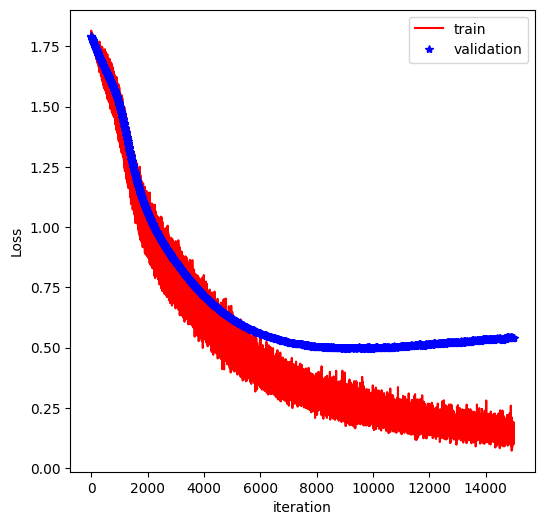

In [12]:
# Plot loss
t = np.arange(iteration - 1)

plt.figure(figsize=(6, 6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

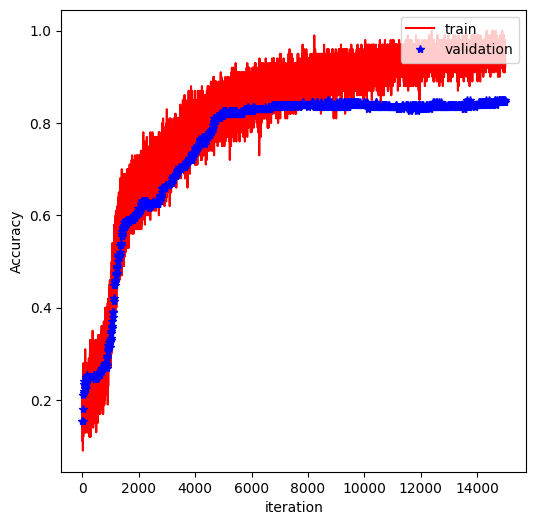

In [13]:
# Plot Accuracies
plt.figure(figsize=(6, 6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [ ]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore checkpoint
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    # Dictionary in which to track accuracies based on grip
    accuracy_by_grip = [
        (
            'cylindrical',
            {
                'correct': 0,
                'total': 0
            }
        ),
        (
            'hook', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'lateral', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'palmar', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'spherical', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
        (
            'tip', 
            {
                'correct': 0, 
                'total': 0
            }
        ),
    ]
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {
            inputs_: x_t,
            labels_: y_t,
            keep_prob_: 1
        }
        
        actual = y_t.argmax(axis=1)
        predicted = sess.run(tf.argmax(logits, 1), feed_dict=feed)
        
        for i in range(len(actual)):
            accuracy_by_grip[actual[i]][1]['total'] += 1
            if actual[i] == predicted[i]:
                accuracy_by_grip[actual[i]][1]['correct'] += 1
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
        
    print('Accuracy by grip:')
    
    for grip, grip_data in accuracy_by_grip:
        print('{}: {:.6f}'.format(grip, grip_data['correct'] / grip_data['total']))
        
    print('\nOverall accuracy: {:.6f}'.format(np.mean(test_acc)))
    